<a href="https://colab.research.google.com/github/vieirafrancisco/machine-learning-ufal/blob/master/deep_learning_cnn_animal_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN para classificação de imagens de animais

### Descrição do dataset:
[link kaggle](https://www.kaggle.com/alessiocorrado99/animals10)

Contém 28 mil imagens de qualidade média de animais pentencendo a 10 categorias: cachorro (dog), gato (cat), cavalo (horse), aranha (spider), borboleta (butterfly), galinha (chicken), orvelha (sheep), vaca (cow), esquilo (squirrel), elefante (elephant).  

Todas as imagens foram coletadas do "google images" e foram veridicadas por humanos.

In [2]:
import os
from google.colab import drive

drive.mount('drive/')

Mounted at drive/


In [3]:
os.chdir('drive/My Drive/UFAL/machine-learning-ufal/video-game-sales')

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from google.colab.patches import cv2_imshow

from sklearn.metrics import accuracy_score
import itertools

from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop, SGD

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
TRANSLATE = {
    "cane": "dog", 
    "cavallo": "horse", 
    "elefante": "elephant", 
    "farfalla": "butterfly", 
    "gallina": "chicken", 
    "gatto": "cat", 
    "mucca": "cow", 
    "pecora": "sheep", 
    "scoiattolo": "squirrel",
    "ragno": "spider"
}
INVERSE_TRANSLATE = {value: key for key, value in TRANSLATE.items()}

DATA_PATH = 'data/raw-img'

# Load Dataset

In [6]:
qtd_img = 500

In [8]:
# Filtrar os animais que tem mais de 500 imagens
def f(animal_name):
  if len(os.listdir(f'data/raw-img/{animal_name}')) >= qtd_img:
    return True
  return False
animals = os.listdir('data/raw-img')
y = {}
for idx, animal in enumerate(filter(f, animals)):
  y[animal] = idx
print(y)

{'elefante': 0, 'cane': 1, 'cavallo': 2, 'farfalla': 3, 'gallina': 4}


In [114]:
# Ler 500 imagens de cada animal escolhido anteriormente
def read_im(animals, qtd_img):
  raw_data = {}
  for animal_name in animals:
    imgs = os.listdir(f'data/raw-img/{animal_name}/')
    for idx, img in enumerate(imgs[:qtd_img]):
      if (idx+1) % int(qtd_img * 0.2) == 0:
        print(TRANSLATE[animal_name], f"<{int((idx+1) * 100 / qtd_img)}%>")
      if animal_name not in raw_data.keys():
        raw_data[animal_name] = []
      raw_data[animal_name].append(cv2.imread(f'data/raw-img/{animal_name}/{img}'))
  return raw_data
#read_im(y.keys(), 500)

No total ficaram 5 animais: Cachorro (dog), Cavalo (horse), Elefante (elephant), Borboleta (butterfly) e Galinha (chicken).  
Dos quais cada um foram utilizadas 500 imagens, totalizando 2500 imagens.  
Obs: A quantidade de imagens é reflexo da limitação de internet e processamento (Mesmo considerando a GPU do colab).

In [9]:
# Padronizar a altura e comprimento das imagens para 200x200 pixels.
# Por conta de que cada imagem tem sua altura x comprimento original.
for animal in y.keys():
  en_animal_name = TRANSLATE[animal]
  for c, img in enumerate(raw_data[animal]):
    simg = cv2.resize(img, (200, 200)) # resize to 200x200 pixels
    cv2.imwrite(f'data/animal-pre/{en_animal_name}_{c}.jpg', simg)

In [9]:
# Associar uma label para cada imagem
labels = []
data = []
for img in os.listdir('data/animal-pre'):
  en_animal_name = img.split('_')[0]
  labels.append(y[INVERSE_TRANSLATE[en_animal_name]])
  data.append(cv2.imread(f'data/animal-pre/{img}'))
data = np.array(data)

In [11]:
from collections import Counter
n_classes = len(set(labels))
print(Counter(labels), n_classes)

Counter({0: 500, 1: 500, 2: 500, 3: 500, 4: 500}) 5


In [12]:
len(os.listdir('data/animal-pre'))

2500

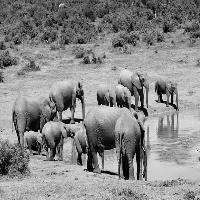

In [14]:
cv2_imshow(data[250])

In [16]:
# shuffle index
index = np.arange(len(data))
np.random.shuffle(index)
print(index[:5])

[ 359  860 2404 2428 2191]


In [19]:
labels = np.array(labels)
labels[index[:5]]

array([3, 0, 4, 4, 4])

In [20]:
# train test split
test_size = 0.2
test_split = int(len(data) * test_size)

X_train = data[index[test_split:]]
X_test = data[index[:test_split]]

y_train = labels[index[test_split:]]
y_test = labels[index[:test_split]]

In [21]:
y_train = to_categorical(y_train, num_classes=n_classes)
y_test = to_categorical(y_test, num_classes=n_classes)

In [22]:
# re-escala 0-1
X_train = X_train / 255
X_test = X_test / 255

In [23]:
X_train.shape

(2000, 200, 200, 3)

# Arquiteturas de CNN e avaliações

In [24]:
# Arquitetura baseada na aula de deep learning
model = Sequential()

In [25]:
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu', input_shape = (200,200,3)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

In [26]:
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

In [27]:
model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation = "softmax"))

In [28]:
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [29]:
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 200, 200, 32)      2432      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 200, 200, 32)      25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 100, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 100, 64)      18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 100, 100, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 64)        0

In [31]:
model.fit(X_train, y_train, epochs=5, verbose=1)

Epoch 1/5
63/63 [==============================] - 651s 10s/step - loss: 2.4160 - accuracy: 0.1970
Epoch 2/5
63/63 [==============================] - 645s 10s/step - loss: 1.6278 - accuracy: 0.2525
Epoch 3/5
63/63 [==============================] - 647s 10s/step - loss: 1.5760 - accuracy: 0.3015
Epoch 4/5
63/63 [==============================] - 646s 10s/step - loss: 1.4511 - accuracy: 0.3795
Epoch 5/5
63/63 [==============================] - 644s 10s/step - loss: 1.4259 - accuracy: 0.4220


In [32]:
model.evaluate(X_test,y_test)

16/16 [==============================] - 34s 2s/step - loss: 1.3802 - accuracy: 0.3320


[1.3802154064178467, 0.3319999873638153]

# Arquitetura baseada no [link](https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-to-classify-photos-of-dogs-and-cats/)

In [35]:
model = Sequential()
# 1
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
model.add(MaxPool2D(pool_size=(2, 2)))
# 2
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPool2D(pool_size=(2, 2)))
# 3
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(n_classes, activation='sigmoid'))

In [37]:
optimizer = SGD(lr=0.001, momentum=0.9)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy']) # loss=binary_crossentropy

In [38]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 200, 200, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 100, 100, 64)      18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 50, 50, 128)       73856     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 25, 25, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 80000)            

In [39]:
model.fit(X_train, y_train, epochs=5, verbose=1)

Epoch 1/5
63/63 [==============================] - 148s 2s/step - loss: 1.6197 - accuracy: 0.1865
Epoch 2/5
63/63 [==============================] - 149s 2s/step - loss: 1.6090 - accuracy: 0.1760
Epoch 3/5
63/63 [==============================] - 149s 2s/step - loss: 1.6091 - accuracy: 0.1785
Epoch 4/5
63/63 [==============================] - 150s 2s/step - loss: 1.6092 - accuracy: 0.1810
Epoch 5/5
63/63 [==============================] - 148s 2s/step - loss: 1.6066 - accuracy: 0.1820


In [40]:
model.evaluate(X_test,y_test)

16/16 [==============================] - 10s 650ms/step - loss: 1.6092 - accuracy: 0.2160


[1.6091781854629517, 0.2160000056028366]

# Tentativa de classificação binária Cachorro (dog) vs Cavalo (horse)

In [115]:
# selecionar as imagens somente de cachorros e cavalos
bin_data = read_im(['cane', 'cavallo'], 500)
bin_data.keys()

dog <20%>
dog <40%>
dog <60%>
dog <80%>
dog <100%>
horse <20%>
horse <40%>
horse <60%>
horse <80%>
horse <100%>


dict_keys(['cane', 'cavallo'])

In [117]:
X = []
for img in bin_data['cane']:
  X.append(cv2.resize(img, (200, 200))) # resize to 200x200 pixels)
for img in bin_data['cavallo']:
  X.append(cv2.resize(img, (200, 200))) # resize to 200x200 pixels)
X = np.array(X)
y = np.array(500 * [0] + 500 * [1])

In [119]:
# shuffle index
index = np.arange(len(X))
np.random.shuffle(index)
print(index[:5])

[953 699  52 661  72]


In [120]:
# train test split
test_size = 0.2
test_split = int(len(X) * test_size)

X_train = X[index[test_split:]]
X_test = X[index[:test_split]]

y_train = y[index[test_split:]]
y_test = y[index[:test_split]]

In [121]:
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

In [122]:
# re-escala
X_train = X_train / 255
X_test = X_test / 255

In [125]:
# Arquitetura baseada na aula de deep learning
model = Sequential()

# bloco 1
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu', input_shape = (200,200,3)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# bloco 2
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

# bloco 3
model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(2, activation = "softmax"))

In [126]:
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [129]:
model.fit(X_train, y_train, epochs=10, verbose=1)

Epoch 1/10
25/25 [==============================] - 251s 10s/step - loss: 0.6858 - accuracy: 0.5175
Epoch 2/10
25/25 [==============================] - 253s 10s/step - loss: 0.6962 - accuracy: 0.5700
Epoch 3/10
25/25 [==============================] - 251s 10s/step - loss: 0.6872 - accuracy: 0.5987
Epoch 4/10
25/25 [==============================] - 250s 10s/step - loss: 0.6968 - accuracy: 0.6350
Epoch 5/10
25/25 [==============================] - 252s 10s/step - loss: 0.5454 - accuracy: 0.7325
Epoch 6/10
25/25 [==============================] - 251s 10s/step - loss: 0.4932 - accuracy: 0.7850
Epoch 7/10
25/25 [==============================] - 252s 10s/step - loss: 0.4346 - accuracy: 0.8075
Epoch 8/10
25/25 [==============================] - 250s 10s/step - loss: 0.3952 - accuracy: 0.8537
Epoch 9/10
25/25 [==============================] - 252s 10s/step - loss: 0.2550 - accuracy: 0.8938
Epoch 10/10
25/25 [==============================] - 251s 10s/step - loss: 0.1999 - accuracy: 0.9275

In [130]:
model.evaluate(X_test, y_test)

7/7 [==============================] - 12s 2s/step - loss: 0.8841 - accuracy: 0.7000


[0.8841336965560913, 0.699999988079071]

# Conclusão
Em geral, os resultados não foram muito bons.  
Pelo o que consigo interpretar, é como se a previsão nas duas arquiteturas apresentadas fossem randômicos. Imagino que possa ser problema de pre-processamento ou até mesmo de quantidade de imagens.  
A ideia que tentei é em vez de utilizar imagens de 5 animais diferente, utilizar somente de 2 (ex: Cachorro vs Gato, Cachorro vs Cavalo). Porém, o resultado também foi ruim, ficando com a accuracy ~70% em teste e ~90% em traino. Acredito que tenha tido overfit, provavelmente por conta da quantidade de imagens.  
Possíveis melhorias:
- [ ] Aumentar a quantidade de imagens
- [ ] Melhorar pré-processamento